In [14]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, KFold
# from sklearn.metrics import accuracy_score
import datetime
# from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load dataset

In [15]:
# Import data
X_full = pd.read_csv('/content/drive/My Drive/PUMPITUP/TrainingSetValues.csv')
X_test_full = pd.read_csv('/content/drive/My Drive/PUMPITUP/TestSetValues.csv')
Y_full = pd.read_csv('/content/drive/My Drive/PUMPITUP/TrainingSetLabels.csv')
submission_file = pd.read_csv("/content/drive/My Drive/PUMPITUP/Format.csv")

X_full.set_index('id',inplace=True)
Y_full.set_index('id',inplace=True)
X_test_full.set_index('id',inplace=True)
X_test_full.reset_index(inplace=True)
submission_file.set_index('id',inplace=True)

In [16]:
X_full.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [17]:
Y_full.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


In [18]:
# join both X_full and Y_full
df_merged = pd.merge(Y_full, X_full, how = 'inner', left_index = True,right_index=True)
df_merged.reset_index(inplace=True)

In [19]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

In [20]:
df_merged.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


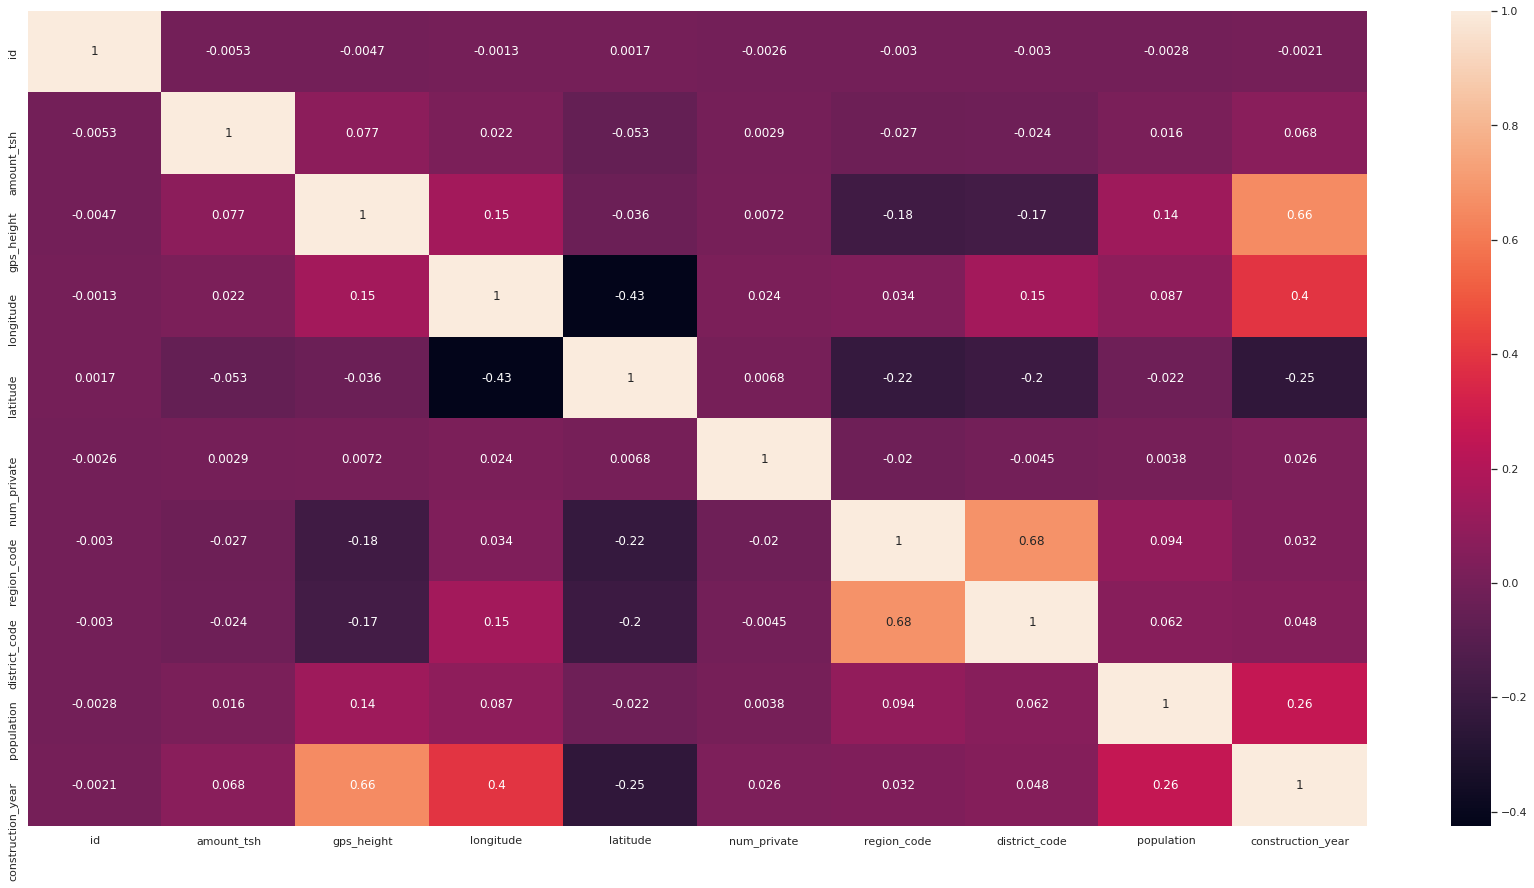

In [21]:
plt.figure(figsize=[30,15])
sns.heatmap(df_merged.corr(), annot=True)

In [22]:
df_merged.isna().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

In [23]:
X_test_full.isna().sum()

id                          0
amount_tsh                  0
date_recorded               0
funder                    869
gps_height                  0
installer                 877
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                 99
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting            821
recorded_by                 0
scheme_management         969
scheme_name              7092
permit                    737
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity  

Experiment on columns

In [24]:
df_merged['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [25]:
df_merged['payment_type'].value_counts()

# Drop payment_type
# Since payment and payment_type have same details one of them can be dropped

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [26]:
df_merged['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [27]:
df_merged['waterpoint_type_group'].value_counts()

# Drop waterpoint_type_group
# Both waterpoint_type and waterpoint_type_group have same details, one of them can be droppped

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [28]:
df_merged['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [29]:
df_merged['quantity_group'].value_counts()

# Drop quantity_group
# Since quantity and quntity_group have same details one of them can be dropped 

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [30]:
df_merged['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [31]:
df_merged['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [32]:
df_merged['source_class'].value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [33]:
df_merged.groupby(['source_class', 'source']).count()

# Drop source_class and source_type

# source_type and source have same data representation, so one of them can be droped
# souce can be keep it has more unique rows
# source_calss can be dropped, since source have more details

id  ...  waterpoint_type_group
source_class source                       ...                       
groundwater  hand dtw                874  ...                    874
             machine dbh           11075  ...                  11075
             shallow well          16824  ...                  16824
             spring                17021  ...                  17021
surface      dam                     656  ...                    656
             lake                    765  ...                    765
             rainwater harvesting   2295  ...                   2295
             river                  9612  ...                   9612
unknown      other                   212  ...                    212
             unknown                  66  ...                     66

[10 rows x 39 columns]

In [34]:
df_merged['water_quality'].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [35]:
df_merged['quality_group'].value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [36]:
df_merged.groupby(['quality_group', 'water_quality']).count()

# Drop quality_group
# Since water_quality provides more deatils than quality_group

id  ...  waterpoint_type_group
quality_group water_quality              ...                       
colored       coloured              490  ...                    490
fluoride      fluoride              200  ...                    200
              fluoride abandoned     17  ...                     17
good          soft                50818  ...                  50818
milky         milky                 804  ...                    804
salty         salty                4856  ...                   4856
              salty abandoned       339  ...                    339
unknown       unknown              1876  ...                   1876

[8 rows x 39 columns]

In [37]:
df_merged['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [38]:
df_merged['management_group'].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [39]:
df_merged.groupby(['management_group', 'management']).count()

# Drop management_group
# Since values in management column are grouped into management_group

id  ...  waterpoint_type_group
management_group management               ...                       
commercial       company             685  ...                    685
                 private operator   1971  ...                   1971
                 trust                78  ...                     78
                 water authority     904  ...                    904
other            other               844  ...                    844
                 other - school       99  ...                     99
parastatal       parastatal         1768  ...                   1768
unknown          unknown             561  ...                    561
user-group       vwc               40507  ...                  40507
                 water board        2933  ...                   2933
                 wua                2535  ...                   2535
                 wug                6515  ...                   6515

[12 rows x 39 columns]

In [40]:
df_merged['scheme_management'].value_counts()

# Drop scheme_management
# It is same as management in above and also it has 3000 Nan values

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [41]:
df_merged['gps_height'].value_counts()/df_merged['gps_height'].count()

 0       0.344074
-15      0.001010
-16      0.000926
-13      0.000926
-20      0.000875
           ...   
 2285    0.000017
 2424    0.000017
 2552    0.000017
 2413    0.000017
 2385    0.000017
Name: gps_height, Length: 2428, dtype: float64

In [42]:
df_merged['amount_tsh'].value_counts()/df_merged['amount_tsh'].count()

0.0         0.700993
500.0       0.052222
50.0        0.041616
1000.0      0.025051
20.0        0.024630
              ...   
8500.0      0.000017
6300.0      0.000017
220.0       0.000017
138000.0    0.000017
12.0        0.000017
Name: amount_tsh, Length: 98, dtype: float64

In [43]:
df_merged.loc[df_merged['amount_tsh']==0]['status_group'].value_counts()

# Drop amount_tsh
# 70% of data has 0 and it is not depend on the output labels

functional                 19706
non functional             18885
functional needs repair     3048
Name: status_group, dtype: int64

In [44]:
df_merged['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [45]:
df_merged['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [46]:
df_merged['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [47]:
df_merged.groupby(['extraction_type_class', 'extraction_type']).count()

# Drop extraction_type_class and extraction_type_group
# extraction_type, extraction_type_group and extraction_type_class have same values
# 2 of them can be dropped

id  ...  waterpoint_type_group
extraction_type_class extraction_type                   ...                       
gravity               gravity                    26780  ...                  26780
handpump              afridev                     1770  ...                   1770
                      india mark ii               2400  ...                   2400
                      india mark iii                98  ...                     98
                      nira/tanira                 8154  ...                   8154
                      other - mkulima/shinyanga      2  ...                      2
                      other - play pump             85  ...                     85
                      other - swn 81               229  ...                    229
                      swn 80                      3670  ...                   3670
                      walimi                        48  ...                     48
motorpump             cemo                          90  ...                     90
                      climax                        32  ...                     32
                      mono                        2865  ...                   2865
other                 other                       6430  ...                   6430
rope pump             other - rope pump            451  ...                    451
submersible           ksb                         1415  ...                   1415
                      submersible                 4764  ...                   4764
wind-powered          windmill                     117  ...                    117

[18 rows x 39 columns]

In [48]:
df_merged['region'].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [49]:
df_merged['region_code'].value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [50]:
df_merged['subvillage'].value_counts()

# Drop subvillage because of it has 19287 different values. also region and region_code provide geographical infomation

Madukani        508
Shuleni         506
Majengo         502
Kati            373
Mtakuja         262
               ... 
Kapela            1
Mabonde           1
Mlogolo Kati      1
Bupuli            1
Masengwa          1
Name: subvillage, Length: 19287, dtype: int64

In [51]:
df_merged['wpt_name'].value_counts()

# Since it has different string values, can be dropped the feature

none                          3563
Shuleni                       1748
Zahanati                       830
Msikitini                      535
Kanisani                       323
                              ... 
Kwa Oigeni Ngonyani              1
Kwa Mzee Kigonembe               1
Mkamba B                         1
Mtera Dam Secondary School       1
Mlumba                           1
Name: wpt_name, Length: 37400, dtype: int64

In [52]:
df_merged['num_private'].value_counts()/df_merged['num_private'].count()

# Drop the feature because it has 98% of zeros

0      0.987256
6      0.001364
1      0.001229
5      0.000774
8      0.000774
         ...   
180    0.000017
213    0.000017
23     0.000017
55     0.000017
94     0.000017
Name: num_private, Length: 65, dtype: float64

In [53]:
df_merged['installer'].value_counts()

#need to normalize data

DWE                         17402
Government                   1825
RWE                          1206
Commu                        1060
DANIDA                       1050
                            ...  
MasjId Takuar                   1
Indiv                           1
HOTEL AND LODGE TANZANIA        1
Water department                1
USAID                           1
Name: installer, Length: 2145, dtype: int64

In [54]:
df_merged['date_recorded'].value_counts()

#need to decompose date_recorded column

2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2011-09-25      1
2004-04-05      1
2011-09-08      1
2013-12-01      1
2011-09-11      1
Name: date_recorded, Length: 356, dtype: int64

In [55]:
df_merged['construction_year'].value_counts()

#need to add new column with decade for each year

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [56]:
df_merged.loc[df_merged['longitude']==0]['latitude'].value_counts()

# So longitude=0 and langitude=-2e-08 are unknown values
# Have to fill with mean

-2.000000e-08    1812
Name: latitude, dtype: int64

In [57]:
df_merged.loc[df_merged['population']!=0]['population'].mean()

# need to update 0 values in population to mean value

281.08716694284436

In [58]:
df_merged['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [59]:
df_merged['public_meeting'].isna().sum()

# Replace the Nan value with most frequent value and map TRUE->1 and FALSE->0

3334

In [60]:
df_merged['recorded_by'].value_counts()

# Drop recorded_by all vales are same

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [61]:
df_merged['subvillage'].value_counts().head(100).sum()

# Drop subvillage because it has large unique value

8781

In [62]:
df_merged['scheme_name'].value_counts().head(100).sum()

11756

In [63]:
df_merged['scheme_name'].isna().sum()

# Drop scheme_name it has lagre unique value and Nan

28166

In [64]:
df_merged['permit'].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [65]:
df_merged['permit'].isna().sum()

# Replace the Nan value with most frequent value and map TRUE->1 and FALSE->0

3056

In [66]:
df_merged['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [67]:
df_merged.loc[df_merged['construction_year']!=0]['construction_year'].mean()

# Replace 0s with mean value

1996.8146855857951

In [68]:
df_merged.loc[df_merged['longitude']!=0]['longitude'].mean()

35.149669123888344

In [69]:
df_merged.loc[df_merged['longitude']!=0]['latitude'].mean()

-5.885572340514868

In [70]:
def date_parser(df):
    date_recorder = list(map(lambda x: datetime.datetime.strptime(str(x), '%Y-%m-%d'),
                             df['date_recorded'].values))
    df['year_recorder'] = list(map(lambda x: int(x.strftime('%Y')), date_recorder))
    df['weekday_recorder'] = list(map(lambda x: int(x.strftime('%w')), date_recorder))
    df['yearly_week_recorder'] = list(map(lambda x: int(x.strftime('%W')), date_recorder))
    df['month_recorder'] = list(map(lambda x: int(x.strftime('%m')), date_recorder))
    df['age'] = df['year_recorder'].values - df['construction_year'].values
    return df

In [71]:
def createDecadeColumn(df):
  df['construction_year'].replace(to_replace = 0, value = 1996, inplace=True)
  df['decade'] = df['construction_year']

  # dividing the column decades
  df['decade'].replace(to_replace = (1960,1961,1962,1963,1964,1965,1966,1967,1968,1969),
                          value ='60s' , inplace=True)
  df['decade'].replace(to_replace = (1970,1971,1972,1973,1974,1975,1976,1977,1978,1979),
                          value ='70s' , inplace=True)
  df['decade'].replace(to_replace = (1980,1981,1982,1983,1984,1985,1986,1987,1988,1989),
                          value ='80s' , inplace=True)
  df['decade'].replace(to_replace = (1990,1991,1992,1993,1994,1995,1996,1997,1998,1999),
                          value ='90s' , inplace=True)
  df['decade'].replace(to_replace = (2000,2001,2002,2003,2004,2005,2006,2007,2008,2009),
                          value ='00s' , inplace=True)
  df['decade'].replace(to_replace = (2010,2011,2012,2013),
                          value ='10s' , inplace=True)

  return df

In [72]:
def reOrderInstallerColumn(df):
  df['installer'].fillna(value='Unknown',inplace=True)

  df['installer'].replace(to_replace = '0', value ='Unknown' , inplace=True)

  df['installer'].replace(to_replace = ('District Water Department', 'District water depar','Distric Water Department'),
                          value ='District water department' , inplace=True)

  df['installer'].replace(to_replace = ('FinW','Fini water','FINI WATER'), value ='Fini Water' , inplace=True)
  df['installer'].replace(to_replace = 'JAICA', value ='Jaica' , inplace=True)

  df['installer'].replace(to_replace = ('COUN', 'District COUNCIL', 'DISTRICT COUNCIL','District Counci', 
                                        'District Council','Council','Counc','District  Council','Distri'),
                                      value ='District council' , inplace=True)

  df['installer'].replace(to_replace = ('RC CHURCH', 'RC Churc', 'RC','RC Ch','RC C', 'RC CH','RC church', 
                                        'RC CATHORIC',) , value ='RC Church' , inplace=True)

  df['installer'].replace(to_replace = ('Central Government','Tanzania Government',
                                        'central government','Cental Government', 'Cebtral Government', 
                                        'Tanzanian Government','Tanzania government', 'Centra Government' ,
                                        'CENTRAL GOVERNMENT', 'TANZANIAN GOVERNMENT','Central govt', 'Centr', 
                                        'Centra govt') , value ='Central government' , inplace=True)

  df['installer'].replace(to_replace = ('World vision', 'World Division','World Vision'),
                                          value ='world vision' , inplace=True)

  df['installer'].replace(to_replace = ('Unisef','UNICEF'),value ='Unicef' , inplace=True)
  df['installer'].replace(to_replace = 'DANID', value ='DANIDA' , inplace=True)

  df['installer'].replace(to_replace = ('villigers', 'villager', 'Villagers', 'Villa', 'Village', 'Villi', 
                                        'Village Council','Village Counil', 'Villages', 'Vill', 'Village community', 
                                        'Villaers', 'Village Community', 'Villag','Villege Council', 'Village council',
                                        'Village  Council','Villagerd', 'Villager', 'Village Technician',
                                        'Village Office','Village community members'),
                                          value ='villagers' , inplace=True)

  df['installer'].replace(to_replace =('Commu','Communit','commu','COMMU', 'COMMUNITY') ,
                                          value ='Community' , inplace=True)

  df['installer'].replace(to_replace = ('GOVERNMENT', 'GOVER', 'GOVERNME', 'GOVERM','GOVERN','Gover','Gove',
                                        'Governme','Governmen' ) ,value ='Government' , inplace=True)

  df['installer'].replace(to_replace = 'Hesawa' ,value ='HESAWA' , inplace=True)

  df['installer'].replace(to_replace = ('Colonial Government') , value ='Colonial government' , inplace=True)
  df['installer'].replace(to_replace = ('Government of Misri') , value ='Misri Government' , inplace=True)
  df['installer'].replace(to_replace = ('Italy government') , value ='Italian government' , inplace=True)
  df['installer'].replace(to_replace = ('British colonial government') , value ='British government' , inplace=True)
  df['installer'].replace(to_replace = ('Concern /government') , value ='Concern/Government' , inplace=True)
  df['installer'].replace(to_replace = ('Village Government') , value ='Village government' , inplace=True)
  df['installer'].replace(to_replace = ('Government and Community') , value ='Government /Community' , inplace=True)
  df['installer'].replace(to_replace = ('Cetral government /RC') , value ='RC church/Central Gover' , inplace=True)
  df['installer'].replace(to_replace = ('Government /TCRS','Government/TCRS') , value ='TCRS /Government' , inplace=True)
  df['installer'].replace(to_replace = ('ADRA /Government') , value ='ADRA/Government' , inplace=True)

  return df

In [73]:
def dropnAddMissingValuesforSpecialColums(df):
  df['funder'].fillna(value='Unknown',inplace=True)
  df['public_meeting'].fillna(value=True,inplace=True)
  df['permit'].fillna(value=True, inplace=True)

  df['funder'].replace(to_replace = '0', value ='Unknown' , inplace=True)
  df['longitude'].replace(to_replace = 0 , value =35.15, inplace=True)
  df['latitude'].replace(to_replace = -2.000000e-08 , value =-5.88, inplace=True)
  df['population'].replace(to_replace = 0 , value =281, inplace=True)

  df.drop(columns=['subvillage', 'num_private', 'date_recorded', 'amount_tsh', 'wpt_name','scheme_name','id','region_code', 
                  'management_group','scheme_management','quantity_group','source_class','source_type','quality_group',
                'payment_type','extraction_type_class','extraction_type', 'waterpoint_type_group', 'recorded_by'],inplace=True )
  return df

In [74]:
df = dropnAddMissingValuesforSpecialColums( reOrderInstallerColumn( createDecadeColumn( date_parser(df_merged.copy()))))

In [75]:
df.isna().sum()

status_group             0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
basin                    0
region                   0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
permit                   0
construction_year        0
extraction_type_group    0
management               0
payment                  0
water_quality            0
quantity                 0
source                   0
waterpoint_type          0
year_recorder            0
weekday_recorder         0
yearly_week_recorder     0
month_recorder           0
age                      0
decade                   0
dtype: int64

In [76]:
df.dropna(axis=0, subset=["status_group"], inplace=True)
Y = pd.DataFrame(df.status_group)        
df.drop(["status_group"], axis=1, inplace=True)
X = df.copy()

In [77]:
X_testNew = dropnAddMissingValuesforSpecialColums( reOrderInstallerColumn( createDecadeColumn( date_parser( X_test_full.copy()))))

In [78]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

my_cols = categorical_cols + numerical_cols

def encoding(df):

  # Preprocessing for numerical data
  numerical_transformer = SimpleImputer(strategy='constant')
  df[numerical_cols] = numerical_transformer.fit_transform(df[numerical_cols])

  # Preprocessing for categorical data
  categorical_transformer = SimpleImputer(strategy='most_frequent')
  df[categorical_cols] = categorical_transformer.fit_transform(df[categorical_cols])

  for i in categorical_cols:
    df[i] = LabelEncoder().fit_transform(df[i].values)
  
  # normalize dataframe
  scaler = StandardScaler()
  dff = scaler.fit_transform(df)
  
  return dff


# # Preprocessing for numerical data
# numerical_transformer = SimpleImputer(strategy='constant')

# # Preprocessing for categorical data
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])


# # Bundle preprocessing for numerical and categorical data
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ])

In [79]:
# Change labels to ints in order to use as y vector
label_encoder = LabelEncoder()
Y["status_group"] = label_encoder.fit_transform(Y.status_group.values)
Y.head()

,status_group
0,0
1,0
2,0
3,2
4,0


Split dataset

In [80]:
X_train = encoding(X[my_cols].copy())
Y_train = Y.copy()
X_test = encoding(X_testNew[my_cols].copy())

# X_train = X[my_cols].copy()
# Y_train = Y.copy()
# X_test = X_testNew[my_cols].copy()

# X_test.head()

**model train testing for various n_estimates and depth, to find better accuracy**

In [ ]:
def modelTraining(n_est, depth):
  model = XGBClassifier(n_estimators=n_est, max_depth=depth)

  model.fit(X_train, Y_train.values.ravel())

  kfold = KFold(n_splits=10, shuffle=True)
  kf_cv_scores = cross_val_score(model, X_train, Y_train.values.ravel(), cv=kfold )
  return kf_cv_scores.mean()

    

In [ ]:
cols = ['n_estimates', 'depth', 'accuracy']
trainingResults = pd.DataFrame(columns = cols)

for n_est in range(1, 11):
  for depth in range(3, 6):
    acc = modelTraining(n_est*50, depth)
    print(n_est*50, depth, acc)
    data = [{'n_estimates': n_est*50,'depth': depth,'accuracy': acc}]
    trainingResults = trainingResults.append(data,ignore_index=True,sort=False)

trainingResults.to_csv(path_or_buf="/content/drive/My Drive/PUMPITUP/accuracyStack.csv")
trainingResults.loc(trainingResults['accuracy'].max())

In [ ]:
trainingResults.to_csv(path_or_buf="/content/drive/My Drive/PUMPITUP/accuracyStack.csv")
# trainingResults.loc(trainingResults['accuracy'].max())
trainingResults.head()

model train with XG Boost Clasiffier

In [81]:
model1 = XGBClassifier(n_estimators=500, max_depth=8)
print(model1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
# Bundle preprocessing and modeling code in a pipeline
# clf = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])

In [82]:
# clf.fit(X_train, Y_train)
# clf.fit(X_train, Y_train.values.ravel())
model1.fit(X_train, Y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [83]:
kfold = KFold(n_splits=10, shuffle=True)
# kf_cv_scores = cross_val_score(clf, X_train, Y_train.values.ravel(), cv=kfold )
kf_cv_scores1 = cross_val_score(model1, X_train, Y_train.values.ravel(), cv=kfold )
print("K-fold CV average score (XGBClassifier): %.4f" % kf_cv_scores1.mean())

K-fold CV average score (XGBClassifier): 0.8131


model train with Random Forest Classifier

In [84]:
model2 = RandomForestClassifier(max_depth=8, random_state=0)
print(model2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [85]:
model2.fit(X_train, Y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [86]:
kf_cv_scores2 = cross_val_score(model2, X_train, Y_train.values.ravel(), cv=kfold )
print("K-fold CV average score (RandomForestClassifier): %.4f" % kf_cv_scores2.mean())

K-fold CV average score (RandomForestClassifier): 0.7419


Save predicted data

In [87]:
preds = model1.predict(X_test)
# preds = clf.predict(X_test)
submission = label_encoder.inverse_transform(preds)
submission_file['status_group'] = submission
submission_file.to_csv(path_or_buf="/content/drive/My Drive/PUMPITUP/Submission.csv")